In [30]:
# %pip install pettingzoo
# %pip install pettingzoo[classic] --no-deps
# %pip install chess

In [31]:
# %pip install ray dm-tree

In [32]:
# %pip install lz4 "ray[tune]" tensorboardX

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
import time

import matplotlib.pyplot as plt
import ray
import ray.rllib.algorithms.ppo as ppo
import torch
import torch.nn as nn

from pettingzoo.test import api_test
from pettingzoo.classic import chess_v6
from pettingzoo.utils.env_logger import EnvLogger
from ray.tune.registry import register_env
from ray.rllib.env.wrappers.pettingzoo_env import PettingZooEnv
from ray.rllib.utils.metrics import (
    ENV_RUNNER_RESULTS,
    EPISODE_RETURN_MEAN,
    EPISODE_LEN_MEAN
)
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.utils.typing import ModelConfigDict
from tqdm import trange

In [35]:
import logging
logging.getLogger("ray").setLevel(logging.ERROR)
logging.getLogger("ray.rllib").setLevel(logging.ERROR)

## Environment

In [36]:
EnvLogger.suppress_output()

https://pettingzoo.farama.org/environments/classic/chess/

Termination Conditions (when rewards are given). The game ends and rewards are assigned when:

- Checkmate - winning player gets +1, losing player gets -1
- Stalemate - both players get 0
- Insufficient material (e.g., king vs king) - both get 0
- 50-move rule - both get 0
- Threefold repetition - both get 0
- Resignation (if implemented) - resigning player loses

In [37]:
env = chess_v6.env()

In [38]:
api_test(env, num_cycles=1_000, verbose_progress=False)

Starting API test
Passed API test


In [39]:
# env = chess_v6.env(render_mode="human")
# env.reset(seed=42)

# for agent in env.agent_iter():

#     observation, reward, terminated, truncated, _ = env.last()

#     if terminated or truncated:
#         action = None
#     else:
#         mask = observation["action_mask"]
#         action = env.action_space(agent).sample(mask)
#         print(action)

#     env.step(action)
#     # time.sleep(10)

In [40]:
# env.close()

## Model

In [41]:
class ChessModel(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)

        # Chess observation has shape: (8, 8, 111) = 7104 values
        # Action mask has shape: (4672,)

        # Process board observation with CNN
        self.conv = nn.Sequential(
            nn.Conv2d(111, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Calculate CNN output size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 111, 8, 8)
            cnn_out = self.conv(dummy_input)
            cnn_output_size = cnn_out.shape[1]

        # Combine with action mask
        self.fc = nn.Sequential(
            nn.Linear(cnn_output_size + 4672, 512),  # CNN output + action mask
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_outputs),
        )

        # Value branch
        self.value_branch = nn.Sequential(
            nn.Linear(cnn_output_size + 4672, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, input_dict, state, seq_lens):
        # Extract observation and action_mask
        obs = input_dict["obs"]

        # Check if it's a dict or already separated
        if isinstance(obs, dict):
            board = obs["observation"]  # Shape: (batch, 8, 8, 111)
            action_mask = obs["action_mask"]  # Shape: (batch, 4672)
        else:
            # Assume obs is the board only
            board = obs
            action_mask = None

        # Convert board to channel-first format
        board = board.permute(0, 3, 1, 2)  # (batch, 111, 8, 8)

        # Process through CNN
        cnn_out = self.conv(board)

        # Combine with action mask if available
        if action_mask is not None:
            combined = torch.cat([cnn_out, action_mask], dim=1)
        else:
            combined = cnn_out

        # Get logits
        logits = self.fc(combined)

        # Mask out illegal moves
        if action_mask is not None:
            # Convert action_mask to the same dtype as logits
            action_mask = action_mask.to(logits.dtype)
            logits = logits + (1.0 - action_mask) * (-1e10)

        # Get value
        self._value_out = self.value_branch(combined).squeeze(-1)

        return logits, state

    def value_function(self):
        return self._value_out

# Register the custom model
ModelCatalog.register_custom_model("chess_model", ChessModel)

In [42]:
ray.init(ignore_reinit_error=True, logging_level="error")

Python version:,3.12.12
Ray version:,2.53.0


In [43]:
register_env(
    "chess",
    lambda cfg: PettingZooEnv(chess_v6.env()),
)

In [44]:
suggested_workers = 1

if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()

In [45]:
config = ppo.PPOConfig()

config = (
    config.environment("chess", env_config={})
    .framework(framework="torch")
    .training(
        model={
            "custom_model": "chess_model",
            "custom_model_config": {},
            "fcnet_hiddens": [],  # Disable default FC since we use custom
            "use_lstm": False,
        },
        lr=0.0001,  # Lower learning rate for chess
        train_batch_size=2048,
    )
    .debugging(log_level="ERROR")
    .resources(num_gpus=num_gpus)
    .env_runners(
        num_cpus_per_env_runner=1,
        num_env_runners=suggested_workers,
        rollout_fragment_length="auto",
    )
    .api_stack(
        enable_rl_module_and_learner=False,
        enable_env_runner_and_connector_v2=False
    )
    .multi_agent(
        policies=["player_0", "player_1"],
        policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: agent_id,
    )
)

In [46]:
trainer = config.build_algo()

(pid=21330) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=21330) E0000 00:00:1768339700.391454   21330 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=21330) E0000 00:00:1768339700.398991   21330 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=21330) W0000 00:00:1768339700.414976   21330 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=21330) W0000 00:00:1768339700.415007   21330 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=21330) W0000 00:00:1768339700.415009   21330 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid lin

In [47]:
num_episodes = 10

todo: add model pretraining to predict legal moves

In [48]:
episode_rewards = []
episode_lengths = []

warnings.filterwarnings('ignore')

for i in trange(num_episodes):
    result = trainer.train()
    # Rewards are kinda useless here, since both agents are training
    episode_rewards.append(result[ENV_RUNNER_RESULTS][EPISODE_RETURN_MEAN])
    episode_lengths.append(result[ENV_RUNNER_RESULTS][EPISODE_LEN_MEAN])
    if i % 5 == 0:
        print(episode_rewards[-1], episode_lengths[-1])

 10%|█         | 1/10 [00:39<05:56, 39.65s/it]

0.0 336.0


 60%|██████    | 6/10 [03:34<02:21, 35.40s/it]

0.0 349.2


100%|██████████| 10/10 [05:46<00:00, 34.67s/it]


A standard chess game averages around 40 full moves (80 half-moves), but this varies significantly by skill level and time control, with amateur games often ending sooner due to blunders (25-35 moves) and professional classical games sometimes extending to 50+ moves before a draw or mate.

If game is significantly longer - players are moving randomly

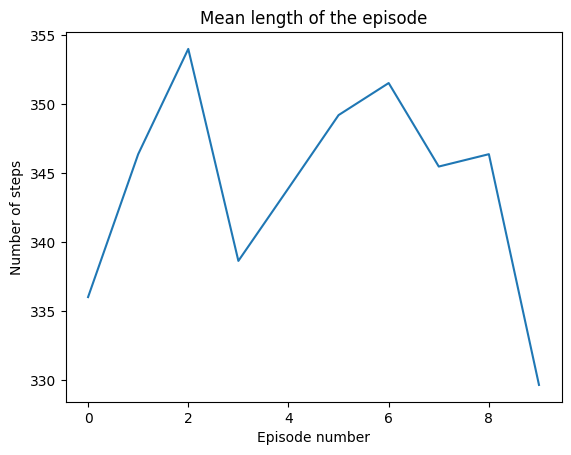

In [52]:
plt.plot(episode_lengths)
plt.ylabel("Number of steps")
plt.xlabel("Episode number")
plt.title("Mean length of the episode")
plt.show()

In [51]:
# todo: comparison of trained agents vs random player